In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pickle
 

# Import h= (yaw,pitch)
with open("/content/drive/My Drive/h_list.txt", "rb") as fp:   # Unpickling
    h = pickle.load(fp)

# Import fl
with open("/content/drive/My Drive/features_left.txt", "rb") as fp:   # Unpickling
    features_left = pickle.load(fp)

# Import fr
with open("/content/drive/My Drive/features_right.txt", "rb") as fp:   # Unpickling
    features_right = pickle.load(fp)

# Import target gaze
with open("/content/drive/My Drive/gaze.txt", "rb") as fp:   # Unpickling
    gazes = pickle.load(fp)


In [3]:
import numpy as np
from os.path import dirname, join as pjoin
import scipy.io as sio
import cv2
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.patches as patches
import math
from math import *
from torch.utils.data import Dataset
import torchvision
import torch.optim as optim
from torchvision import models 
from torchvision import transforms
import torch.nn as nn
from PIL import Image
from matplotlib import cm
import torch
from torch.utils.data.sampler import SubsetRandomSampler
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
h2=torch.as_tensor(h).cuda()

In [5]:
gazes2=torch.as_tensor(np.array(gazes)).cuda()

In [6]:
data_in = torch.cat((h2,features_right, features_left), 1)

In [7]:
data_in2= data_in.clone().detach()

In [8]:
data_in2 = ((data_in2.T - data_in2.mean(axis = 1))/data_in2.std(axis = 1)).T

In [9]:

class MLPDataset(Dataset):
    """prep_data_for_MLP."""

    def __init__(self, data_in,gaze, transform=None):
        self.data_in = data_in
        self.target = gazes
        self.transform = transform



    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        x = self.data_in[idx]
        y=  self.target[idx]
        if self.transform:
              x = self.transform(x)
        #sample = {'input': x, 'gaze': y}
        return x,y

In [10]:
from torch.utils.data import Dataset, DataLoader

In [11]:
preprocess = transforms.Compose([
        transforms.Lambda(lambda x: x.double()),

        ])
dataset = MLPDataset(data_in2,gazes2,transform=preprocess)

In [12]:
validation_split = .2
shuffle_dataset = True
random_seed= 42
batch_size= 128
# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)

In [13]:
#Function to create a Pretrained Resnet Model with a Fully Connected Layer
# (out_1: ouput of 1st layer), (out_2: ouput of 2nd layer)
def createModel_MLP(hidden):
    model = nn.Sequential(
      nn.Flatten(),
      nn.Linear(2048*2+2, hidden),
      nn.ReLU(),
      nn.Linear(hidden, 128),
      nn.ReLU(),
      nn.Linear(128, 3 ),
    )
    
    model.double() #double to set variables to double
    #Sending the device to the GPU if avaliable
    model.to(device)

    return model

Starting training
Epoch Number: 0
loss: 31.0700128154349
val loss: 7.545045667824686
Epoch Number: 1
loss: 29.815956212844185
val loss: 7.605753597489819
Epoch Number: 2
loss: 29.694638301989805
val loss: 7.476167103674154
Epoch Number: 3
loss: 29.314425954270448
val loss: 7.5090350156298395
Epoch Number: 4
loss: 29.612395750925884
val loss: 7.558741187773747
Epoch Number: 5
loss: 29.442167308856167
val loss: 7.4138561468225666
Epoch Number: 6
loss: 29.41348356601696
val loss: 7.571071624884098
Epoch Number: 7
loss: 29.380953167965497
val loss: 7.505232859137025
Epoch Number: 8
loss: 29.225808770144457
val loss: 7.435970605271609
Epoch Number: 9
loss: 29.30059680522803
val loss: 7.456028970192376
Epoch Number: 10
loss: 29.059090008183734
val loss: 7.4812773251451805
Epoch Number: 11
loss: 29.372307928434314
val loss: 7.405822395034271
Epoch Number: 12
loss: 29.28768449431446
val loss: 7.482557777663625
Epoch Number: 13
loss: 29.065191299574455
val loss: 7.4668337150033155
Epoch Number:

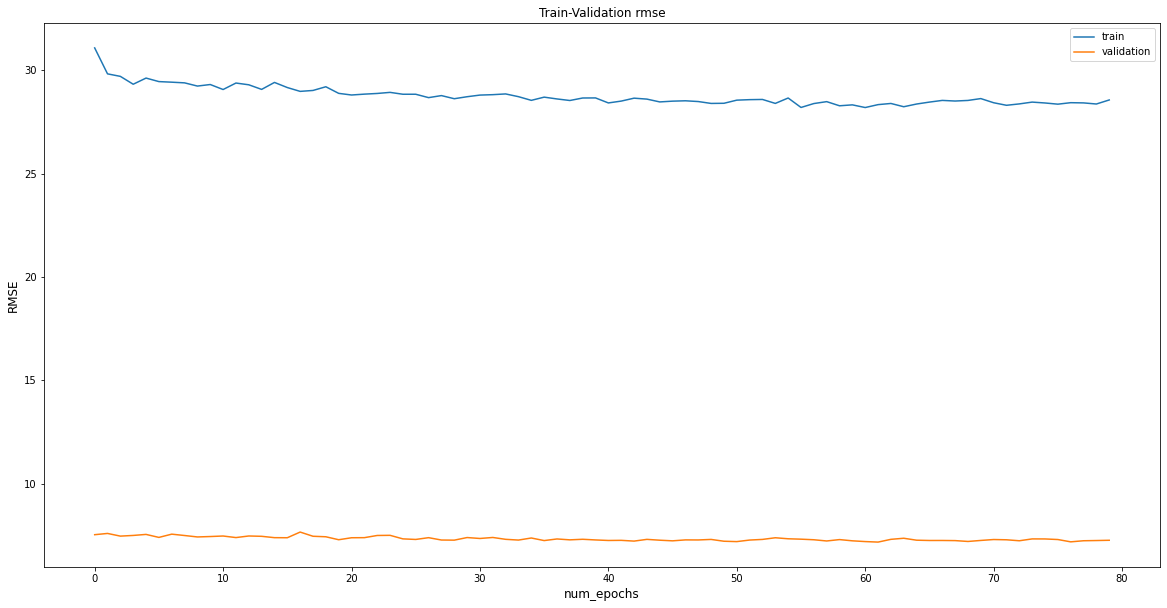

In [14]:
#Function to handle training
#(model: model to train), (criterion: loss function for the model), (optimizer, what optimizer to use)
def train(model, criterion, optimizer, file, epochs=80, trainLoss=[], validationLoss=[]):
    #device = torch.device("cpu")
    print("Starting training")
    for epoch in range(epochs):
        print(f"Epoch Number: {epoch}")

        testAccuracy = 0
        totalLoss = 0

        for i in range(len(train_loader)):
            #Put model into training mode
            model.train()
            batch= next(iter(train_loader))
            x=batch[0]
            y=batch[1].to(device)
            #Zero out gradients
            optimizer.zero_grad()
            #Make a prediction
            y_hat = model(x)
            
            #Calculate the loss
            loss = criterion(y_hat, y)
            l = torch.sqrt(loss)
            #Update the total loss
            totalLoss += l.item()
            #Initiate backpropagation
            l.backward()
            
            #Update parameters
            optimizer.step()

            #testAccuracy += (y_hat == y).sum().item()
        trainLoss.append(totalLoss)
        print(f"loss: {totalLoss}")
        
        valAccuracy = 0
        totalLoss = 0
        
        
        for j in range(len(validation_loader)):
            # Put the model into evaluation mode
            banch= next(iter(validation_loader))
            x=banch[0]
            y=banch[1].to(device)
            model.eval()
            y_pred= model(x)
            #print(y_pred)
            loss = criterion(y_pred, y)
            l = torch.sqrt(loss)
            totalLoss += l
        print(f"val loss: {totalLoss}")
        validationLoss.append(totalLoss)
        #Save our model for each epoch
    fig = plt.figure(figsize=(20,10))
    plt.title("Train-Validation rmse")
    plt.plot(trainLoss, label='train')
    plt.plot(validationLoss, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('RMSE', fontsize=12)
    plt.legend(loc='best')
    plt.savefig('MLP_RMSE_normalized.png')


    torch.save(model.state_dict(), file)
    torch.save(model.state_dict(), "/content/drive/MyDrive/"+file)
    return trainLoss, validationLoss, model

#Create a model using our function
model = createModel_MLP(256)
#Define our loss and optimizers
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)
#Specify output file name
file = "MLP.pth" #save model

#Try to use Colab's GPU here, otherwise it will take a long time to train.
output = train(model, criterion, optimizer, file)